# Reconstruct from traces

Purpose of this notebook :

* Convert Tincan records to usable network images 
* Extract some first metrics
* Create preliminary viz of the activity
* Check test data

Tincan/XAPI records have already been stored in MongoDB using a [custom xApi crawler script](https://github.com/sical/meta-education/blob/master/xapi/xapi-crawler.py) 

In [124]:
import json
import os
from pymongo import MongoClient
import datetime

# import config
with open(os.path.join(os.getcwd(),"../config/config.json"),"rb") as f:
    config = json.load(f)

# connect to mongo
client = MongoClient('localhost', 27017)
db = client["metaEducation"] 

### Parser functions

Functions used to convert Tincan API answers into networks

In [182]:
action_codes = {
    "81" : "login",
    "284" : "login",
    "292" : "viewed",
    "144" : "search",
    "102" : "create",
    "103" : "delete",
    "160" : "update"
}

def get_action(type):
    if type[-1] == "/":
        return type.split("/")[-2]
    else :
        code = type.split("/")[-1]
        try :
            int(code)
            return action_codes[code]
        except ValueError:
            return code

def get_project_id(data):
    return data["project"]["id"]
         
# statements parsers 
def create_elements(G, element_type, data):
    
    if element_type == "Node" :
        G.add_node(data["_id"], attr_dict=data)
    elif element_type == "Edge" :
        G.add_edge(data["from"], data["to"], attr_dict=data)
    else :
        raise ValueError("Wrong element type %s"%element_type)
    return G

def delete_elements(G, element_type, data):
    
    if element_type == "Node" :
        G.remove_node(data["_id"])
    elif element_type == "Edge" :
        G.remove_edge(data["from"], data["to"])
    else :
        raise ValueError("Wrong element type %s"%element_type)
    return G

def update_elements(G, element_type, data):

    if element_type == "Node" :
        for change in data_changed:
            G.node[data["_id"]][change] = data[change]
    elif element_type == "Edge" :
        for change in data_changed:
            G.edge[data["_id"]][change] = data[change]
    else :
        raise ValueError("Wrong element type %s"%element_type)
    return G
    


### Use test data to parse networks

385 results
----------
Final state: 7 nodes and 6 edges in 48 actions
----------
update 26
create 15
move 5
delete 2
----------
Final state: 12 nodes and 11 edges in 140 actions
----------
update 88
create 26
move 23
delete 3
----------


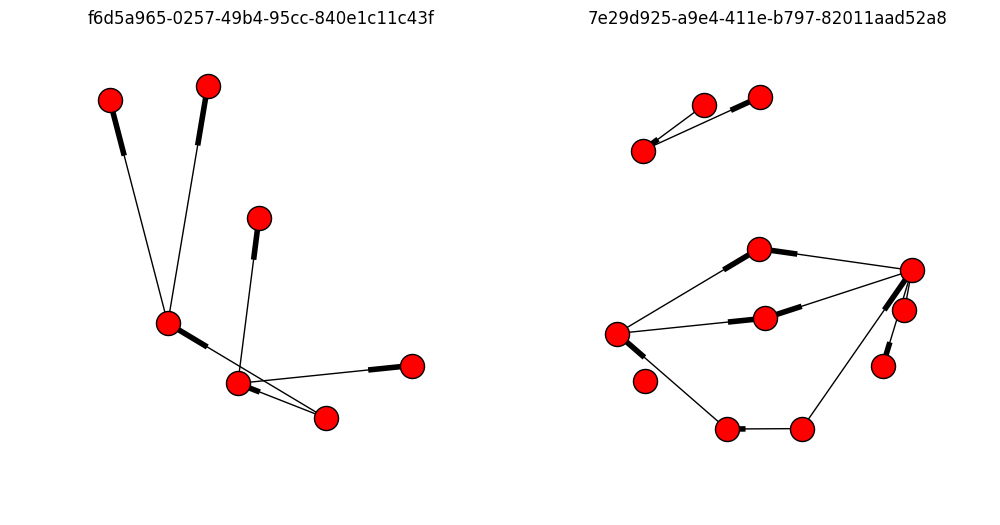

In [199]:
from collections import Counter 
import networkx as nx

# convert date string to datetime object
start = datetime.datetime(2016, 10, 18, 0, 0, 0)
end = datetime.datetime(2016, 10, 18, 23, 50, 0)

# query
q = { 'stored': {'$lt': end, '$gte': start} }

print "%s results"%db.statements.find(q).count()
print "-"*10

# store different informations about the network
networks = {}

# container for all network states 
actions = {}

# extract infos 
for statement in db.statements.find(q):
    
    # default state 
    project_id=None
    
    # store action infos
    action = {}
    action["type"] = get_action(statement["verb"]["id"])
    action["ts"] = statement["stored"]
    
    
    if action["type"] in ["access","loggedin","viewed","close"] : 
        pass # ignore those actions
    else :
        element_type = statement["object"]["definition"]["type"].split("#")[1]
        
        if element_type == "Renkan":
            
            if action["type"] == "create": # create new project
                data = statement["object"]["definition"]["extensions"]["http://www-w3-org/ns/activitystreams#Data"]
                new_id = data["id"]
                networks[new_id] = nx.DiGraph()
                actions[new_id] = []
                
        elif element_type == "View":
            pass
        
        elif element_type == "Node" or element_type == "Edge":
            
            data = statement["object"]["definition"]["extensions"]["http://www-w3-org/ns/activitystreams#Data"]
            project_id = data["project"]["id"]
            
            if action["type"] == "create":
                create_elements(networks[project_id], element_type, data )
                
            elif action["type"] == "update" or action["type"] == "move" :
                try: 
                    data_changed = statement["object"]["definition"]["extensions"]["http://www-w3-org/ns/activitystreams#DataChanged"] 
                    update_elements(networks[project_id], element_type, data_changed )
                except KeyError:
                    pass # ignore if nothing in DataChanges
            elif action["type"] == "delete":
                delete_elements(networks[project_id], element_type, data )
        
            action["nodes"] = networks[project_id].nodes() 
            action["edges"] = networks[project_id].edges()
            action["statement"] = statement
            action["project_id"] = project_id
            
            actions[project_id].append(action)


fig, ax = plt.subplots(1, 2, figsize=(12,6) )

for i,network_id in enumerate(actions):
    actions[ network_id ].sort(key=lambda c: c["ts"]) # sort by time
    
    print "Final state: %s nodes and %s edges in %s actions"%(len(networks[network_id].nodes()), len(networks[network_id].edges()), len(actions[network_id]))
    print "-"*10
    
    for c in Counter([a["type"] for a in actions[network_id]]).most_common() : print c[0], c[1]
    print "-"*10
    
    plt.sca(ax[i])
    nx.draw(networks[network_id])
    plt.title(network_id)

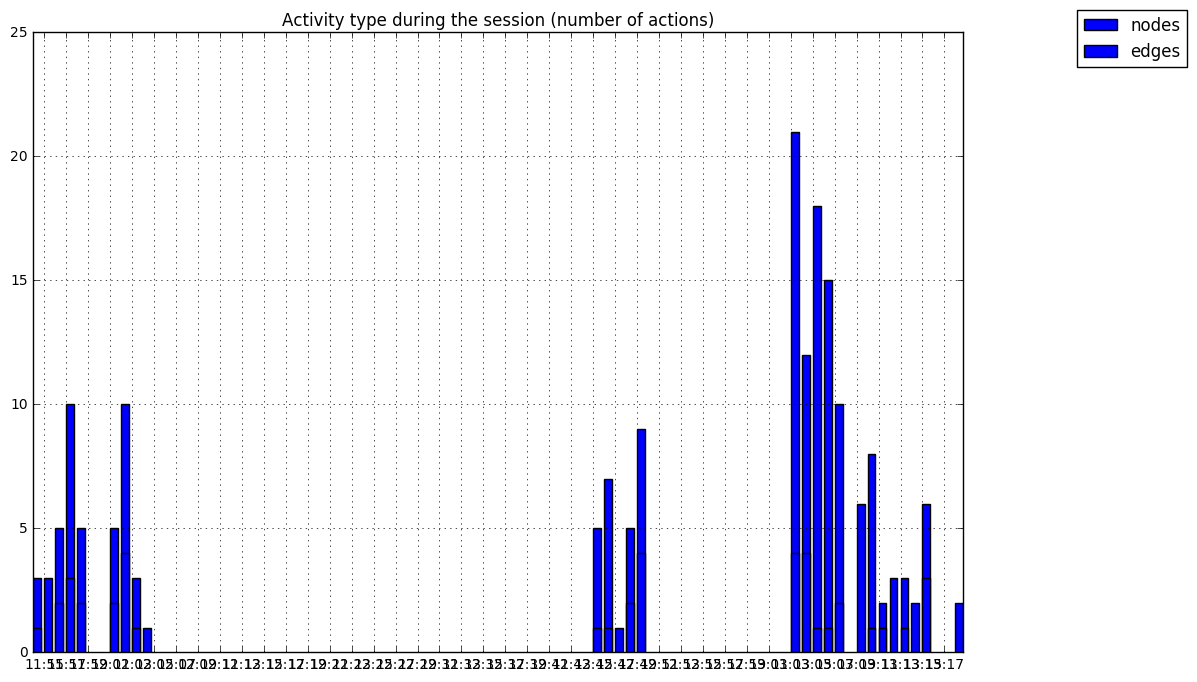

In [168]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import dates as mdates

def roundTime(dt=None, roundTo=60):
   """Round a datetime object to any time laps in seconds
   dt : datetime.datetime object, default now.
   roundTo : Closest number of seconds to round to, default 1 minute.
   Author: Thierry Husson 2012 - Use it as you want but don't blame me.
   """
   if dt == None : dt = datetime.datetime.now()
   seconds = (dt.replace(tzinfo=None) - dt.min).seconds
   rounding = (seconds+roundTo/2) // roundTo * roundTo
   return dt + datetime.timedelta(0,rounding-seconds,-dt.microsecond)


def get_actions_count_per_minutes(actions):
    
    # round timestamps to activity by minutes
    timestamps = [ roundTime(a["ts"]) for a in actions]

    # count 
    count = Counter(timestamps).most_common() 
    count.sort(key=lambda c: c[0]) # sort by time

    x = [c[0] for c in count] # time
    y = [c[1] for c in count] # values
    return x, y


# draw
fig, ax = plt.subplots(1, 1, figsize=(12,8) )
hfmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=2))
ax.xaxis.set_major_formatter(hfmt)
ax.xaxis_date()
ax.grid(which='both')


# plt.legend(['nodes', 'edges'], loc='upper right', bbox_to_anchor=(1.25, 1.05))
# plt.title("Evolution of nodes and edges over time")

# plot time activity 
x_time, y_total = get_actions_count_per_minutes(actions)
plt.bar(x_time, y_total, width=0.0005)

x_time, y_create = get_actions_count_per_minutes([a for a in actions if a["type"] == "create"])
plt.bar(x_time, y_create, width=0.0005)

# x_time, y_delete = get_actions_count_per_minutes([a for a in actions if a["type"] == "delete"])
# plt.bar(x_time, y_delete, width=0.0005)

# x_time, y_delete = get_actions_count_per_minutes([a for a in actions if a["type"] == "update"])
# plt.plot(x_time, y_delete)

# x_time, y_move = get_actions_count_per_minutes([a for a in actions if a["type"] == "move"])
# plt.plot(x_time, y_move)

plt.legend(['nodes', 'edges', 'total', 'create', 'delete', 'update', 'move'], loc='upper right', bbox_to_anchor=(1.25, 1.05))
plt.title("Activity type during the session (number of actions)")

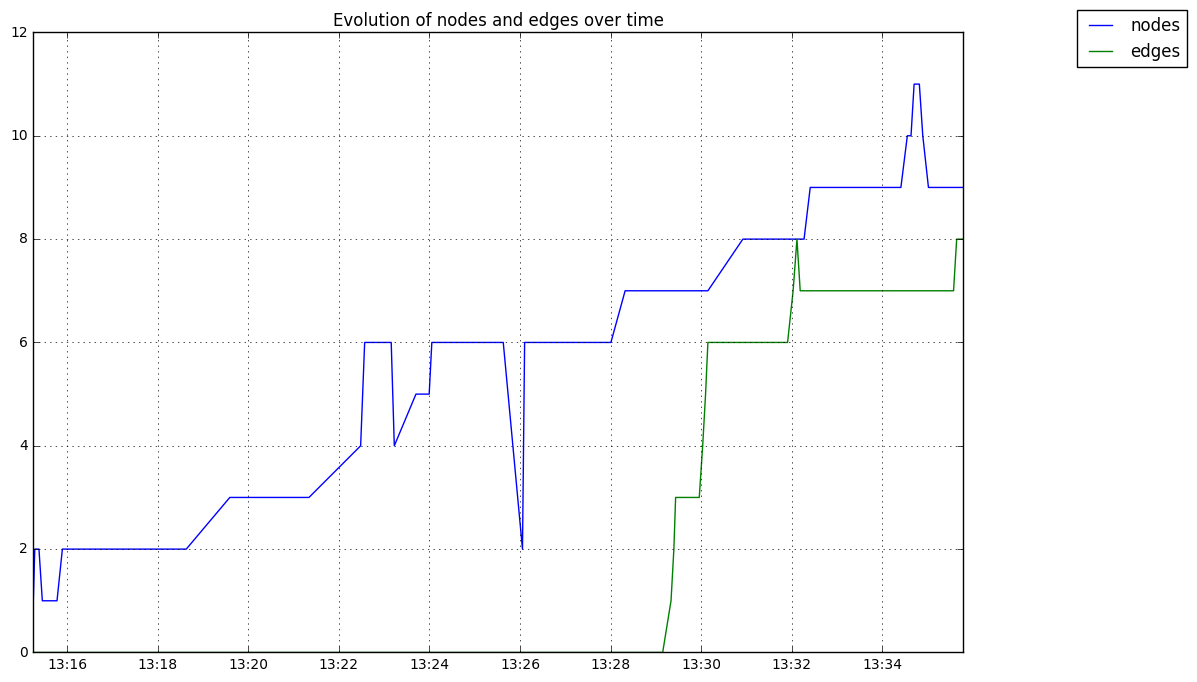

In [75]:
import numpy as np

# network size evolution

fig, ax = plt.subplots(1, 1, figsize=(12,8))

# grid
hfmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=2))
ax.xaxis.set_major_formatter(hfmt)
ax.grid(which='both')     

x = [a["ts"] for a in actions]
y_nodes_count = [len(a["nodes"]) for a in actions]
y_edges_count = [len(a["edges"]) for a in actions]

plt.plot(x, y_nodes_count)
plt.plot(x, y_edges_count)
plt.legend(['nodes', 'edges'], loc='upper right', bbox_to_anchor=(1.25, 1.05))
plt.title("Evolution of nodes and edges over time")